<a href="https://colab.research.google.com/github/sophiezydfifi/207fall-project-ding-peteh-valadez-zhang/blob/main/207_Milestone_workbook_final%20Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Challenges and Pre-processing**


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBRegressor
import seaborn as sns
import altair as alt
alt.data_transformers.disable_max_rows()
from google.colab import files

In [2]:
# upload the file and please replace the file link
df = pd.read_csv("/content/NBA Player Stats and Salaries_2010-2025.csv")
print(df.shape)
df.head()

(7298, 31)


Player    Salary  Year Pos  Age Team   G  GS    MP   FG  ...  \
0       Kobe Bryant  23034375  2010  SG   31  LAL  73  73  38.8  9.8  ...   
1   Jermaine O'Neal  23016000  2010   C   31  MIA  70  70  28.4  5.6  ...   
2     Tracy McGrady  22843124  2010  SG   30  NYK  30  24  22.4  3.0  ...   
3        Tim Duncan  22183220  2010   C   33  SAS  78  77  31.3  7.2  ...   
4  Shaquille O'Neal  21000000  2010   C   37  CLE  53  53  23.4  4.9  ...   

     FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
0  0.811  1.1  4.3   5.4  5.0  1.5  0.3  3.2  2.6  27.0  
1  0.720  1.8  5.2   6.9  1.3  0.4  1.4  1.8  3.0  13.6  
2  0.746  0.7  2.4   3.1  3.3  0.5  0.5  1.5  1.3   8.2  
3  0.725  2.8  7.3  10.1  3.2  0.6  1.5  1.8  1.9  17.9  
4  0.496  1.8  4.9   6.7  1.5  0.3  1.2  2.0  3.2  12.0  

[5 rows x 31 columns]

In [3]:
# Quick structure overview
df.info()

# Check missing values
df.isnull().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7298 entries, 0 to 7297
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7298 non-null   object 
 1   Salary  7298 non-null   int64  
 2   Year    7298 non-null   int64  
 3   Pos     7298 non-null   object 
 4   Age     7298 non-null   int64  
 5   Team    7298 non-null   object 
 6   G       7298 non-null   int64  
 7   GS      7298 non-null   int64  
 8   MP      7298 non-null   float64
 9   FG      7298 non-null   float64
 10  FGA     7298 non-null   float64
 11  FG%     7278 non-null   float64
 12  3P      7298 non-null   float64
 13  3PA     7298 non-null   float64
 14  3P%     6713 non-null   float64
 15  2P      7298 non-null   float64
 16  2PA     7298 non-null   float64
 17  2P%     7253 non-null   float64
 18  eFG%    7278 non-null   float64
 19  FT      7298 non-null   float64
 20  FTA     7298 non-null   float64
 21  FT%     7096 non-null   float64
 22  

3P%       585
FT%       202
2P%        45
FG%        20
eFG%       20
Pos         0
Player      0
G           0
Team        0
GS          0
MP          0
FGA         0
Age         0
Salary      0
Year        0
3PA         0
3P          0
FG          0
2PA         0
2P          0
dtype: int64

In [4]:
# For the missing values. They are all data derived from other non-missing columns. Hence I can fill percentage columns with 0
perc_cols = ["3P%", "FT%", "2P%", "FG%", "eFG%"]
df[perc_cols] = df[perc_cols].fillna(0)

# Double check
df[perc_cols].isnull().sum()

3P%     0
FT%     0
2P%     0
FG%     0
eFG%    0
dtype: int64

In [5]:
# I want to adjust all the salary from different years to the level of 2025 based on the NBA cap. (https://www.spotrac.com/nba/cba/)
#Salary Cap Maximum values (from  the NBA salary Cap table, 2010–2025)
cap_data = {
    "Year": [
        2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024, 2025
    ],
    "Cap": [
        58040000, 58044000, 58044000, 58679000,
        63065000, 70000000, 94143000, 99093000,
        101869000, 109140000, 109140000, 112414000,
        123655000, 136021000, 140588000, 154647000
    ]
}

cap_df = pd.DataFrame(cap_data)
cap_df

Year        Cap
0   2010   58040000
1   2011   58044000
2   2012   58044000
3   2013   58679000
4   2014   63065000
5   2015   70000000
6   2016   94143000
7   2017   99093000
8   2018  101869000
9   2019  109140000
10  2020  109140000
11  2021  112414000
12  2022  123655000
13  2023  136021000
14  2024  140588000
15  2025  154647000

In [6]:
# Merge salary cap info into NBA dataset
df_cap = df.merge(cap_df, on="Year", how="left")

In [7]:
# sort each player by year in order
df_sort = df_cap.sort_values(["Player", "Year"]).reset_index(drop=True)

# specificy lag candidate columns
stat_cols = [
    "Age", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%",
    "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%",
    "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"
]

# created lagged performance stats by 1 year
for col in stat_cols:
    df_sort[f"{col}_lag1"] = df_sort.groupby("Player")[col].shift(1)

# drop first season per player with no previous year
df_lagged = df_sort.dropna(subset = [f"{col}_lag1" for col in stat_cols])

# sanity check lagged stats
[c for c in df_lagged.columns if "_lag1" in c]

['Age_lag1',
 'G_lag1',
 'GS_lag1',
 'MP_lag1',
 'FG_lag1',
 'FGA_lag1',
 'FG%_lag1',
 '3P_lag1',
 '3PA_lag1',
 '3P%_lag1',
 '2P_lag1',
 '2PA_lag1',
 '2P%_lag1',
 'eFG%_lag1',
 'FT_lag1',
 'FTA_lag1',
 'FT%_lag1',
 'ORB_lag1',
 'DRB_lag1',
 'TRB_lag1',
 'AST_lag1',
 'STL_lag1',
 'BLK_lag1',
 'TOV_lag1',
 'PF_lag1',
 'PTS_lag1']

In [8]:
# sanity check
df_lagged = df_lagged.copy()
print(df_lagged.columns)

Index(['Player', 'Salary', 'Year', 'Pos', 'Age', 'Team', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'Cap', 'Age_lag1', 'G_lag1', 'GS_lag1', 'MP_lag1', 'FG_lag1',
       'FGA_lag1', 'FG%_lag1', '3P_lag1', '3PA_lag1', '3P%_lag1', '2P_lag1',
       '2PA_lag1', '2P%_lag1', 'eFG%_lag1', 'FT_lag1', 'FTA_lag1', 'FT%_lag1',
       'ORB_lag1', 'DRB_lag1', 'TRB_lag1', 'AST_lag1', 'STL_lag1', 'BLK_lag1',
       'TOV_lag1', 'PF_lag1', 'PTS_lag1'],
      dtype='object')


In [9]:
# stats of interest
rank_stats = ['MP_lag1', 'DRB_lag1', 'AST_lag1', 'TOV_lag1', 'PTS_lag1']

# ranks stats per season, creating new rank columns, ties get average
for col in rank_stats:
    df_lagged[f"{col}_rank"] = (
        df_lagged.groupby("Year")[col]
          .rank(ascending=False,
                method="average")
    )

# builds cummulative stat rank score as new column
rank_cols = [f"{c}_rank" for c in rank_stats]
df_lagged["rank_score"] = df_lagged[rank_cols].sum(axis=1)

# lag ranked score
df_lagged["rank_score_lag1"] = df_lagged.groupby("Player")["rank_score"].shift(1)

# compute delta from previous year, drop nulls
df_lagged["rank_score_delta"] = df_lagged["rank_score"] - df_lagged["rank_score_lag1"]
df_lagged = df_lagged.dropna(subset = ["rank_score_delta"])

In [10]:
# drop same year stats and cat columns
feature_cols = ["Cap", "rank_score_delta"] + [f"{col}_lag1" for col in stat_cols]
target_col = ["Salary"]

df_lagged = df_lagged[["Player", "Year", "Salary"] + feature_cols]

In [11]:
# filter for 2020 and forward
df_2020_plus = df_lagged[df_lagged["Year"] >= 2020].copy()

In [12]:
# sanity check
df_2020_plus

Player  Year    Salary        Cap  rank_score_delta  Age_lag1  \
22       Aaron Gordon  2020  19863636  109140000            -433.0      23.0   
23       Aaron Gordon  2021  22102631  112414000              86.5      24.0   
24       Aaron Gordon  2022  18974611  123655000             143.0      25.0   
25       Aaron Gordon  2023  21938322  136021000             -31.5      26.0   
26       Aaron Gordon  2024  21898084  140588000              40.0      27.0   
...               ...   ...       ...        ...               ...       ...   
7287  Ziaire Williams  2024   4953130  140588000              77.5      21.0   
7288  Ziaire Williams  2025   6133005  154647000            -343.0      22.0   
7291  Zion Williamson  2023  14350804  136021000            -204.5      20.0   
7292  Zion Williamson  2024  35015681  140588000             -43.0      22.0   
7293  Zion Williamson  2025  36725670  154647000              85.0      23.0   

      G_lag1  GS_lag1  MP_lag1  FG_lag1  ...  FT%_lag1  ORB_lag1  DRB_lag1  \
22      78.0     78.0     33.8      6.0  ...     0.731       1.7       5.7   
23      62.0     62.0     32.5      5.4  ...     0.674       1.7       5.9   
24      50.0     50.0     27.7      4.6  ...     0.651       1.5       4.1   
25      75.0     75.0     31.7      5.8  ...     0.743       1.7       4.2   
26      68.0     68.0     30.2      6.3  ...     0.608       2.4       4.1   
...      ...      ...      ...      ...  ...       ...       ...       ...   
7287    37.0      4.0     15.2      2.3  ...     0.773       0.4       1.7   
7288    51.0     15.0     20.4      2.9  ...     0.827       0.7       2.8   
7291    61.0     61.0     33.2     10.4  ...     0.698       2.7       4.5   
7292    29.0     29.0     33.0      9.8  ...     0.714       2.0       5.0   
7293    70.0     70.0     31.5      8.9  ...     0.702       1.7       4.1   

      TRB_lag1  AST_lag1  STL_lag1  BLK_lag1  TOV_lag1  PF_lag1  PTS_lag1  
22         7.4       3.7       0.7       0.7       2.1      2.2      16.0  
23         7.7       3.7       0.8       0.6       1.6      2.0      14.4  
24         5.7       3.2       0.7       0.7       1.9      1.8      12.4  
25         5.9       2.5       0.6       0.6       1.8      2.0      15.0  
26         6.6       3.0       0.8       0.8       1.4      1.9      16.3  
...        ...       ...       ...       ...       ...      ...       ...  
7287       2.1       0.9       0.4       0.2       1.0      1.6       5.7  
7288       3.5       1.5       0.7       0.2       1.3      1.7       8.2  
7291       7.2       3.7       0.9       0.6       2.7      2.2      27.0  
7292       7.0       4.6       1.1       0.6       3.4      2.2      26.0  
7293       5.8       5.0       1.1       0.7       2.8      2.3      22.9  

[1913 rows x 31 columns]

In [13]:
#Classify the salary into low, mid and high categories
# Define quantile cutoffs
q33 = df_2020_plus["Salary"].quantile(0.33)
q66 = df_2020_plus["Salary"].quantile(0.66)


# Create a categorical variable for salary tiers
def categorize_salary(salary):
    if salary <= q33:
        return "Low"
    elif salary <= q66:
        return "Medium"
    else:
        return "High"

class_order = ["Low", "Medium", "High"]

df_2020_plus["Salary_Tier"] = df_2020_plus["Salary"].apply(categorize_salary)

# Quick check of class balance
print(df_2020_plus["Salary_Tier"].value_counts())

Salary_Tier
High      651
Low       631
Medium    631
Name: count, dtype: int64


In [14]:
# check shape to head into splitting
df_working = df_2020_plus.copy()

print('Shape of data', df_working.shape)
df_working.head(10)
print(df_working.columns)

Shape of data (1913, 32)
Index(['Player', 'Year', 'Salary', 'Cap', 'rank_score_delta', 'Age_lag1',
       'G_lag1', 'GS_lag1', 'MP_lag1', 'FG_lag1', 'FGA_lag1', 'FG%_lag1',
       '3P_lag1', '3PA_lag1', '3P%_lag1', '2P_lag1', '2PA_lag1', '2P%_lag1',
       'eFG%_lag1', 'FT_lag1', 'FTA_lag1', 'FT%_lag1', 'ORB_lag1', 'DRB_lag1',
       'TRB_lag1', 'AST_lag1', 'STL_lag1', 'BLK_lag1', 'TOV_lag1', 'PF_lag1',
       'PTS_lag1', 'Salary_Tier'],
      dtype='object')


In [15]:
# train val test preserving time order
train_df = df_working[df_working["Year"].isin([2020, 2021, 2022])]
val_df   = df_working[df_working["Year"].isin([2023, 2024])]
test_df  = df_working[df_working["Year"] == 2025]

# **EDA and visualizations**

**Here we doing some EDA and Data Visulization before modelling**

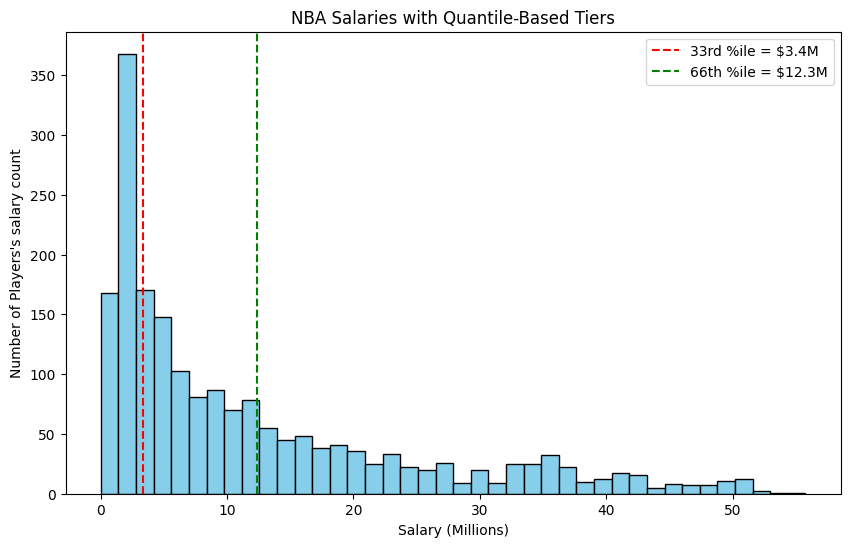

In [16]:
plt.figure(figsize=(10,6))
plt.hist(df_working["Salary"]/1e6, bins=40, color="skyblue", edgecolor="black")
plt.axvline(q33/1e6, color="red", linestyle="--", label=f"33rd %ile = ${q33/1e6:.1f}M")
plt.axvline(q66/1e6, color="green", linestyle="--", label=f"66th %ile = ${q66/1e6:.1f}M")
plt.title("NBA Salaries with Quantile-Based Tiers")
plt.xlabel("Salary (Millions)")
plt.ylabel("Number of Players's salary count")
plt.legend()
plt.show()

In [17]:
# scatter plolt salary vs season pts avg
brush = alt.selection_interval()
scatter = alt.Chart(df_cap).mark_circle().encode(
    x = alt.X("PTS:Q", title = "Season Points"),
    y = alt.Y("Salary:Q", title = "Salary"),
    color = alt.condition(brush, "Pos:N", alt.value("lightgray")),
    tooltip = ["Player","Team","Year","PTS","Salary","Pos"]
).add_params(brush).properties(title="Points vs Salary")
scatter

alt.Chart(...)

In [18]:
cor_features = ['Salary', 'Cap', 'rank_score_delta', 'Age_lag1', 'G_lag1', 'GS_lag1',
       'MP_lag1', 'FG_lag1', 'FGA_lag1', 'FG%_lag1', '3P_lag1', '3PA_lag1',
       '3P%_lag1', '2P_lag1', '2PA_lag1', '2P%_lag1', 'eFG%_lag1', 'FT_lag1',
       'FTA_lag1', 'FT%_lag1', 'ORB_lag1', 'DRB_lag1', 'TRB_lag1', 'AST_lag1',
       'STL_lag1', 'BLK_lag1', 'TOV_lag1', 'PF_lag1', 'PTS_lag1']

In [19]:
# numeric features correlation heatmap
corr = df_working[cor_features].corr().stack().reset_index()
corr.columns = ["feature_x","feature_y","corr"]

heatmap = alt.Chart(corr).mark_rect().encode(
    x = alt.X("feature_x:N", sort = cor_features, title = ""),
    y = alt.Y("feature_y:N", sort = cor_features, title = ""),
    color = alt.Color("corr:Q", scale = alt.Scale(scheme = "redblue", domain = [-1,1])),
    tooltip = ["feature_x","feature_y","corr"]
).properties(title = "Salary Correlation Heatmap")

In [20]:
heatmap

alt.Chart(...)

# Feature Selection Based on EDA

In [21]:
target = "Salary"

# Keep only correlations involving the target variable
corr_target = corr[
    ((corr['feature_x'] == target) | (corr['feature_y'] == target)) &
    (corr['feature_x'] != corr['feature_y'])
].copy()

# Sort by absolute correlation or raw correlation (your choice)
corr_target_sorted = corr_target.sort_values(by='corr', ascending=False)

print(corr_target_sorted)

            feature_x         feature_y      corr
812          PTS_lag1            Salary  0.779481
28             Salary          PTS_lag1  0.779481
7              Salary           FG_lag1  0.769692
203           FG_lag1            Salary  0.769692
232          FGA_lag1            Salary  0.752636
8              Salary          FGA_lag1  0.752636
17             Salary           FT_lag1  0.711652
493           FT_lag1            Salary  0.711652
754          TOV_lag1            Salary  0.707924
26             Salary          TOV_lag1  0.707924
406          2PA_lag1            Salary  0.702897
14             Salary          2PA_lag1  0.702897
18             Salary          FTA_lag1  0.698379
522          FTA_lag1            Salary  0.698379
377           2P_lag1            Salary  0.696067
13             Salary           2P_lag1  0.696067
6              Salary           MP_lag1  0.693891
174           MP_lag1            Salary  0.693891
667          AST_lag1            Salary  0.636639


# Feature Selection

In [22]:
# features of interest
selected_features = ['rank_score_delta', 'MP_lag1', 'DRB_lag1', 'AST_lag1', 'TOV_lag1', 'PTS_lag1']


# define features for the training
x_train = train_df.drop(columns=['Age_lag1', 'G_lag1', 'GS_lag1', 'FG_lag1', 'FGA_lag1',
       'FG%_lag1', '3P_lag1', '3PA_lag1', '3P%_lag1', '2P_lag1', '2PA_lag1',
       '2P%_lag1', 'eFG%_lag1', 'FT_lag1', 'FTA_lag1', 'FT%_lag1', 'ORB_lag1',
       'TRB_lag1', 'STL_lag1', 'BLK_lag1', 'PF_lag1', 'Cap'])
y_train = train_df["Salary"]

x_val = val_df.drop(columns=['Age_lag1', 'G_lag1', 'GS_lag1', 'FG_lag1', 'FGA_lag1',
       'FG%_lag1', '3P_lag1', '3PA_lag1', '3P%_lag1', '2P_lag1', '2PA_lag1',
       '2P%_lag1', 'eFG%_lag1', 'FT_lag1', 'FTA_lag1', 'FT%_lag1', 'ORB_lag1',
       'TRB_lag1', 'STL_lag1', 'BLK_lag1', 'PF_lag1', 'Cap'])
y_val = val_df["Salary"]

x_test = test_df.drop(columns=['Age_lag1', 'G_lag1', 'GS_lag1', 'FG_lag1', 'FGA_lag1',
       'FG%_lag1', '3P_lag1', '3PA_lag1', '3P%_lag1', '2P_lag1', '2PA_lag1',
       '2P%_lag1', 'eFG%_lag1', 'FT_lag1', 'FTA_lag1', 'FT%_lag1', 'ORB_lag1',
       'TRB_lag1', 'STL_lag1', 'BLK_lag1', 'PF_lag1', 'Cap'])
y_test = test_df["Salary"]

# refine features after more feature engineering
x_train_refined = x_train.drop(columns=["Player", "Year", "Salary"])

x_val_refined = x_val.drop(columns=["Player", "Year", "Salary"])

x_test_refined = x_test.drop(columns=["Player", "Year", "Salary"])



In [24]:
#Many ML models (regression, KNN, neural nets) need features on similar scales.
#Tree models (Random Forest, Gradient Boosting) don’t need scaling, but it’s fine to keep a standardized version for consistency.
from sklearn.preprocessing import StandardScaler

#numeric standardization
scaler = StandardScaler()

# fits standardization on x_train keeps column names and preserve row shuffle
x_train_refined = pd.DataFrame(
    scaler.fit_transform(x_train_refined[selected_features]),
    columns = selected_features,
    index = x_train_refined.index
)

# fits same scaler on x_val keeps column names and preserve row shuffle
x_val_refined = pd.DataFrame(
    scaler.transform(x_val_refined[selected_features]),
    columns = selected_features,
    index = x_val_refined.index
)

# fits same scaler on x_test keeps column names and preserve rows
x_test_refined = pd.DataFrame(
    scaler.transform(x_test_refined[selected_features]),
    columns = selected_features,
    index = x_test_refined.index
)

In [25]:
# put together standardized features
print("x_train_refined shape:", x_train_refined.shape)
print("y_train shape:", y_train.shape)
print("x_val_refined shape:", x_val_refined.shape)
print("y_val shape:", y_val.shape)
print("x_test_refined shape:", x_test_refined.shape)
print("y_test shape:", y_test.shape)

x_train_refined shape: (912, 6)
y_train shape: (912,)
x_val_refined shape: (652, 6)
y_val shape: (652,)
x_test_refined shape: (349, 6)
y_test shape: (349,)


# Baseline

For the baseline linear regression model, we only want to use the raw inputs without any derived features.

In [ ]:
# 1. Define the lag-based features for the baseline LR model
baseline_features = ['MP_lag1', 'DRB_lag1', 'AST_lag1', 'TOV_lag1', 'PTS_lag1']

# 2. Build design matrices for baseline linear regression
X_train_base = train_df[baseline_features].copy()
y_train_base = train_df["Salary"].copy()

X_val_base   = val_df[baseline_features].copy()
y_val_base   = val_df["Salary"].copy()

X_test_base  = test_df[baseline_features].copy()
y_test_base  = test_df["Salary"].copy()

In [ ]:
# Fit baseline LR
lr_baseline = LinearRegression()
lr_baseline.fit(X_train_base, y_train_base)

# Predict
y_train_pred_base = lr_baseline.predict(X_train_base)
y_val_pred_base   = lr_baseline.predict(X_val_base)
y_test_pred_base  = lr_baseline.predict(X_test_base)

# Evaluate
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

print("=== Baseline Linear Regression (Lag Features Only) ===")
print("Train RMSE:", rmse(y_train_base, y_train_pred_base))
print("Val   RMSE:", rmse(y_val_base,   y_val_pred_base))
print("Test  RMSE:", rmse(y_test_base,  y_test_pred_base))

print("Train MAE :", mae(y_train_base, y_train_pred_base))
print("Val   MAE :", mae(y_val_base,   y_val_pred_base))
print("Test  MAE :", mae(y_test_base,  y_test_pred_base))

=== Baseline Linear Regression (Lag Features Only) ===
Train RMSE: 7383517.807158659
Val   RMSE: 7493356.277984552
Test  RMSE: 8028150.625903169
Train MAE : 5364982.456472064
Val   MAE : 5369077.176864517
Test  MAE : 5750416.9634226


In [ ]:

# 2. Convert predicted salary -> predicted tiers (Low / Medium / High)
y_train_pred_tier_base = pd.Series(
    y_train_pred_base, index=y_train_base.index
).apply(categorize_salary)

y_val_pred_tier_base = pd.Series(
    y_val_pred_base, index=y_val_base.index
).apply(categorize_salary)

y_test_pred_tier_base = pd.Series(
    y_test_pred_base, index=y_test_base.index
).apply(categorize_salary)

# 3. True tiers from the split dataframes
y_train_true_tier = train_df.loc[y_train_base.index, "Salary_Tier"]
y_val_true_tier   = val_df.loc[y_val_base.index,   "Salary_Tier"]
y_test_true_tier  = test_df.loc[y_test_base.index, "Salary_Tier"]

# 4. Helper to print classification metrics nicely
def print_classification_results(split_name, y_true, y_pred):
    print(f"\n=== {split_name} Tier Classification (Baseline LR) ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n",
          classification_report(y_true, y_pred, target_names=class_order))

# 5. Report results for train / val / test
print_classification_results("Train", y_train_true_tier, y_train_pred_tier_base)
print_classification_results("Val",   y_val_true_tier,   y_val_pred_tier_base)
print_classification_results("Test",  y_test_true_tier,  y_test_pred_tier_base)


=== Train Tier Classification (Baseline LR) ===
Accuracy: 0.6096491228070176

Confusion Matrix:
 [[237   4  65]
 [ 22 127 150]
 [ 79  36 192]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.70      0.77      0.74       306
      Medium       0.76      0.42      0.55       299
        High       0.47      0.63      0.54       307

    accuracy                           0.61       912
   macro avg       0.64      0.61      0.61       912
weighted avg       0.64      0.61      0.61       912


=== Val Tier Classification (Baseline LR) ===
Accuracy: 0.661042944785276

Confusion Matrix:
 [[173   5  37]
 [ 10 122  89]
 [ 51  29 136]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.74      0.80      0.77       215
      Medium       0.78      0.55      0.65       221
        High       0.52      0.63      0.57       216

    accuracy                           0.66       652
   macro avg

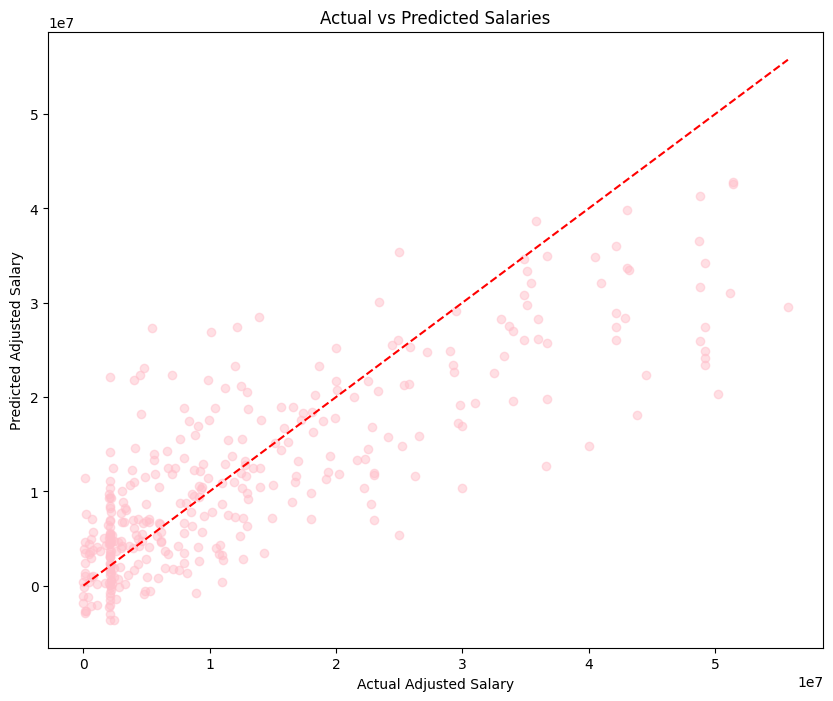

In [ ]:
# plotting test data results
plt.figure(figsize = (10, 8))
plt.scatter(y_test, y_test_pred_base, alpha = 0.5, color = "pink")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Adjusted Salary")
plt.ylabel("Predicted Adjusted Salary")
plt.title("Actual vs Predicted Salaries")
plt.show()

# Feature-reengineering improvement

# **Improvement 1 - Regression Neural Network (RNN) **

There are several RNN models with different hyper parameters and we will label them clearly

**1)RNN Base Model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(x_train_refined.shape[1],)),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),

    layers.Dense(32, activation='relu'),

    layers.Dense(1)  # single continuous salary output
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.MeanAbsoluteError(name="mae")]
)

model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )
]

history = model.fit(
    x_train_refined, y_train,
    validation_data=(x_val_refined, y_val),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 276605943414784.0000 - mae: 11726473.0000 - rmse: 16615305.0000 - val_loss: 299632924033024.0000 - val_mae: 11934032.0000 - val_rmse: 17309908.0000 - learning_rate: 0.0010
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 288388867424256.0000 - mae: 11967946.0000 - rmse: 16953894.0000 - val_loss: 299632051617792.0000 - val_mae: 11934005.0000 - val_rmse: 17309884.0000 - learning_rate: 0.0010
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 280816353542144.0000 - mae: 11600644.0000 - rmse: 16749898.0000 - val_loss: 299627790204928.0000 - val_mae: 11933884.0000 - val_rmse: 17309760.0000 - learning_rate: 0.0010
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 282665622175744.0000 - mae: 11678958.0000 - rmse: 16801098.0000 - val_loss: 299613730897920.0000 - val_mae: 11933504.0000 - val_rmse: 17309354.0000 - learning_rate: 0.0010
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 285175292362752.

In [ ]:
import numpy as np

train_mse, train_rmse, train_mae = model.evaluate(x_train_refined, y_train, verbose=0)
val_mse,   val_rmse,   val_mae   = model.evaluate(x_val_refined,   y_val,   verbose=0)
test_mse,  test_rmse,  test_mae  = model.evaluate(x_test_refined,  y_test,  verbose=0)

print("Train RMSE:", train_rmse)
print("Val   RMSE:", val_rmse)
print("Test  RMSE:", test_rmse)

print("Train MAE:", train_mae)
print("Val   MAE:", val_mae)
print("Test  MAE:", test_mae)

Train RMSE: 7057286.0
Val   RMSE: 6711355.5
Test  RMSE: 7341607.5
Train MAE: 4937792.5
Val   MAE: 4558566.0
Test  MAE: 5106630.5


In [ ]:

# Tier classification based on regression NN


# 1. Predict continuous salary on train / val / test
y_train_pred_reg = model.predict(x_train_refined).flatten()
y_val_pred_reg   = model.predict(x_val_refined).flatten()
y_test_pred_reg  = model.predict(x_test_refined).flatten()

# 2. Convert predicted salary → predicted tier (Low / Medium / High)
y_train_pred_tier = pd.Series(y_train_pred_reg).apply(categorize_salary)
y_val_pred_tier   = pd.Series(y_val_pred_reg).apply(categorize_salary)
y_test_pred_tier  = pd.Series(y_test_pred_reg).apply(categorize_salary)

# 3. Get true salary tiers from dataset using indices of y_train / y_val / y_test
y_train_true_tier = df_working.loc[y_train.index, "Salary_Tier"]
y_val_true_tier   = df_working.loc[y_val.index,   "Salary_Tier"]
y_test_true_tier  = df_working.loc[y_test.index,  "Salary_Tier"]

# 4. Evaluate classification

print("=== Train Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_train_true_tier, y_train_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_train_true_tier, y_train_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_train_true_tier, y_train_pred_tier, target_names=class_order))

print("\n=== Val Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_val_true_tier, y_val_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_val_true_tier, y_val_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_val_true_tier, y_val_pred_tier, target_names=class_order))

print("\n=== Test Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_test_true_tier, y_test_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_true_tier, y_test_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_test_true_tier, y_test_pred_tier, target_names=class_order))


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
=== Train Tier Classification (Regression NN) ===
Accuracy: 0.6052631578947368

Confusion Matrix:
 [[243   6  57]
 [ 21 134 144]
 [ 77  55 175]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.71      0.79      0.75       306
      Medium       0.69      0.45      0.54       299
        High       0.47      0.57      0.51       307

    accuracy                           0.61       912
   macro avg       0.62      0.60      0.60       912
weighted avg       0.62      0.61      0.60       912


=== Val Tier Classification (Regression NN) ===
Accuracy: 0.6671779141104295

Confusion Matrix:
 [[173   1  41]
 [  6 137  78]
 [ 50  41 125]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.76      0.80      0.78       215
      Medium       0.77      0.62      0.69       22

**2) RNN Model 2 More Regularlization and Smaller Learning Rate**

In [ ]:
model = keras.Sequential([
    layers.Input(shape = (x_train_refined.shape[1],)),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation = "relu"),
    layers.Dense(1)
])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0005),
    loss = "mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.MeanAbsoluteError(name="mae")]
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 20,
        restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 20,
        min_lr = 1e-6
    )
]

history = model.fit(
    x_train_refined, y_train,
    validation_data = (x_val_refined, y_val),
    epochs = 300,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

train_mse, train_rmse, train_mae = model.evaluate(x_train_refined, y_train, verbose=0)
val_mse,   val_rmse,   val_mae   = model.evaluate(x_val_refined,   y_val,   verbose=0)
test_mse,  test_rmse,  test_mae  = model.evaluate(x_test_refined,  y_test,  verbose=0)

print("Train RMSE:", train_rmse)
print("Val   RMSE:", val_rmse)
print("Test  RMSE:", test_rmse)

print("Train MAE:", train_mae)
print("Val   MAE:", val_mae)
print("Test  MAE:", test_mae)

# Tier classification based on regression NN


# 1. Predict continuous salary on train / val / test
y_train_pred_reg = model.predict(x_train_refined).flatten()
y_val_pred_reg   = model.predict(x_val_refined).flatten()
y_test_pred_reg  = model.predict(x_test_refined).flatten()

# 2. Convert predicted salary → predicted tier (Low / Medium / High)
y_train_pred_tier = pd.Series(y_train_pred_reg).apply(categorize_salary)
y_val_pred_tier   = pd.Series(y_val_pred_reg).apply(categorize_salary)
y_test_pred_tier  = pd.Series(y_test_pred_reg).apply(categorize_salary)

# 3. Get true salary tiers from dataset using indices of y_train / y_val / y_test
y_train_true_tier = df_working.loc[y_train.index, "Salary_Tier"]
y_val_true_tier   = df_working.loc[y_val.index,   "Salary_Tier"]
y_test_true_tier  = df_working.loc[y_test.index,  "Salary_Tier"]

# 4. Evaluate classification

print("=== Train Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_train_true_tier, y_train_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_train_true_tier, y_train_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_train_true_tier, y_train_pred_tier, target_names=class_order))

print("\n=== Val Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_val_true_tier, y_val_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_val_true_tier, y_val_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_val_true_tier, y_val_pred_tier, target_names=class_order))

print("\n=== Test Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_test_true_tier, y_test_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_true_tier, y_test_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_test_true_tier, y_test_pred_tier, target_names=class_order))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 256900566351872.0000 - mae: 11238100.0000 - rmse: 16014278.0000 - val_loss: 299633058250752.0000 - val_mae: 11934037.0000 - val_rmse: 17309912.0000 - learning_rate: 5.0000e-04
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 283701581709312.0000 - mae: 11876091.0000 - rmse: 16816132.0000 - val_loss: 299632890478592.0000 - val_mae: 11934032.0000 - val_rmse: 17309908.0000 - learning_rate: 5.0000e-04
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 265336469323776.0000 - mae: 11288091.0000 - rmse: 16283788.0000 - val_loss: 299632420716544.0000 - val_mae: 11934018.0000 - val_rmse: 17309894.0000 - learning_rate: 5.0000e-04
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 270179934142464.0000 - mae: 11506687.0000 - rmse: 16433055.0000 - val_loss: 299631212756992.0000 - val_mae: 11933985.0000 - val_rmse: 17309858.0000 - learning_rate: 5.0000e-04
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

**3) RNN Model 3-Fast Learner**

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(x_train_refined.shape[1],)),
    layers.Dense(256, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(64, activation = "relu"),
    layers.Dense(1)
])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.003),
    loss = "mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.MeanAbsoluteError(name="mae")]
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 20,
        restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 20,
        min_lr = 1e-6
    )
]

history = model.fit(
    x_train_refined, y_train,
    validation_data = (x_val_refined, y_val),
    epochs = 300,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

train_mse, train_rmse, train_mae = model.evaluate(x_train_refined, y_train, verbose=0)
val_mse,   val_rmse,   val_mae   = model.evaluate(x_val_refined,   y_val,   verbose=0)
test_mse,  test_rmse,  test_mae  = model.evaluate(x_test_refined,  y_test,  verbose=0)

print("Train RMSE:", train_rmse)
print("Val   RMSE:", val_rmse)
print("Test  RMSE:", test_rmse)

print("Train MAE:", train_mae)
print("Val   MAE:", val_mae)
print("Test  MAE:", test_mae)

# Tier classification based on regression NN


# 1. Predict continuous salary on train / val / test
y_train_pred_reg = model.predict(x_train_refined).flatten()
y_val_pred_reg   = model.predict(x_val_refined).flatten()
y_test_pred_reg  = model.predict(x_test_refined).flatten()

# 2. Convert predicted salary → predicted tier (Low / Medium / High)
y_train_pred_tier = pd.Series(y_train_pred_reg).apply(categorize_salary)
y_val_pred_tier   = pd.Series(y_val_pred_reg).apply(categorize_salary)
y_test_pred_tier  = pd.Series(y_test_pred_reg).apply(categorize_salary)

# 3. Get true salary tiers from dataset using indices of y_train / y_val / y_test
y_train_true_tier = df_working.loc[y_train.index, "Salary_Tier"]
y_val_true_tier   = df_working.loc[y_val.index,   "Salary_Tier"]
y_test_true_tier  = df_working.loc[y_test.index,  "Salary_Tier"]

# 4. Evaluate classification

print("=== Train Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_train_true_tier, y_train_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_train_true_tier, y_train_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_train_true_tier, y_train_pred_tier, target_names=class_order))

print("\n=== Val Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_val_true_tier, y_val_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_val_true_tier, y_val_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_val_true_tier, y_val_pred_tier, target_names=class_order))

print("\n=== Test Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_test_true_tier, y_test_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_true_tier, y_test_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_test_true_tier, y_test_pred_tier, target_names=class_order))


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,009 (168.00 KB)

 Trainable params: 43,009 (168.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 285087312642048.0000 - mae: 11866243.0000 - rmse: 16874476.0000 - val_loss: 299623126138880.0000 - val_mae: 11933746.0000 - val_rmse: 17309626.0000 - learning_rate: 0.0030
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 246622961270784.0000 - mae: 10971641.0000 - rmse: 15686413.0000 - val_loss: 299431463223296.0000 - val_mae: 11928640.0000 - val_rmse: 17304088.0000 - learning_rate: 0.0030
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 269426855247872.0000 - mae: 11414175.0000 - rmse: 16406377.0000 - val_loss: 298166830235648.0000 - val_mae: 11895949.0000 - val_rmse: 17267508.0000 - learning_rate: 0.0030
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 263978622124032.0000 - mae: 11536658.0000 - rmse: 16241183.0000 - val_loss: 293283251093504.0000 - val_mae: 11772203.0000 - val_rmse: 17125514.0000 - learning_rate: 0.0030
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 264477391978496.

**4) RNN Model 4-Deeper Network**


In [ ]:
model = keras.Sequential([
    layers.Input(shape=(x_train_refined.shape[1],)),
    layers.Dense(128, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(64, activation = "relu"),
    layers.Dense(32, activation = "relu"),
    layers.Dense(16, activation = "relu"),
    layers.Dense(1)
])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = "mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.MeanAbsoluteError(name="mae")]
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 20,
        restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 20,
        min_lr = 1e-6
    )
]

history = model.fit(
    x_train_refined, y_train,
    validation_data = (x_val_refined, y_val),
    epochs = 300,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

train_mse, train_rmse, train_mae = model.evaluate(x_train_refined, y_train, verbose=0)
val_mse,   val_rmse,   val_mae   = model.evaluate(x_val_refined,   y_val,   verbose=0)
test_mse,  test_rmse,  test_mae  = model.evaluate(x_test_refined,  y_test,  verbose=0)

print("Train RMSE:", train_rmse)
print("Val   RMSE:", val_rmse)
print("Test  RMSE:", test_rmse)

print("Train MAE:", train_mae)
print("Val   MAE:", val_mae)
print("Test  MAE:", test_mae)

# Tier classification based on regression NN


# 1. Predict continuous salary on train / val / test
y_train_pred_reg = model.predict(x_train_refined).flatten()
y_val_pred_reg   = model.predict(x_val_refined).flatten()
y_test_pred_reg  = model.predict(x_test_refined).flatten()

# 2. Convert predicted salary → predicted tier (Low / Medium / High)
y_train_pred_tier = pd.Series(y_train_pred_reg).apply(categorize_salary)
y_val_pred_tier   = pd.Series(y_val_pred_reg).apply(categorize_salary)
y_test_pred_tier  = pd.Series(y_test_pred_reg).apply(categorize_salary)

# 3. Get true salary tiers from dataset using indices of y_train / y_val / y_test
y_train_true_tier = df_working.loc[y_train.index, "Salary_Tier"]
y_val_true_tier   = df_working.loc[y_val.index,   "Salary_Tier"]
y_test_true_tier  = df_working.loc[y_test.index,  "Salary_Tier"]

# 4. Evaluate classification

print("=== Train Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_train_true_tier, y_train_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_train_true_tier, y_train_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_train_true_tier, y_train_pred_tier, target_names=class_order))

print("\n=== Val Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_val_true_tier, y_val_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_val_true_tier, y_val_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_val_true_tier, y_val_pred_tier, target_names=class_order))

print("\n=== Test Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_test_true_tier, y_test_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_true_tier, y_test_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_test_true_tier, y_test_pred_tier, target_names=class_order))


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,289 (110.50 KB)

 Trainable params: 28,289 (110.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 268807826309120.0000 - mae: 11390392.0000 - rmse: 16391690.0000 - val_loss: 299632622043136.0000 - val_mae: 11934022.0000 - val_rmse: 17309900.0000 - learning_rate: 0.0010
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 290388610908160.0000 - mae: 12006718.0000 - rmse: 17023118.0000 - val_loss: 299620341121024.0000 - val_mae: 11933643.0000 - val_rmse: 17309544.0000 - learning_rate: 0.0010
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 259998596726784.0000 - mae: 11514303.0000 - rmse: 16122511.0000 - val_loss: 299458944303104.0000 - val_mae: 11929096.0000 - val_rmse: 17304882.0000 - learning_rate: 0.0010
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 295322588807168.0000 - mae: 12112842.0000 - rmse: 17170802.0000 - val_loss: 298332924674048.0000 - val_mae: 11898808.0000 - val_rmse: 17272316.0000 - learning_rate: 0.0010
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 255323004731392.

**5) RNN Model 5-Simpler Model**

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(x_train_refined.shape[1],)),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.15),
    layers.Dense(32, activation = "relu"),
    layers.Dropout(0.1),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss = "mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.MeanAbsoluteError(name="mae")]
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 20,
        restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 20,
        min_lr = 1e-6
    )
]

history = model.fit(
    x_train_refined, y_train,
    validation_data = (x_val_refined, y_val),
    epochs = 300,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

train_mse, train_rmse, train_mae = model.evaluate(x_train_refined, y_train, verbose=0)
val_mse,   val_rmse,   val_mae   = model.evaluate(x_val_refined,   y_val,   verbose=0)
test_mse,  test_rmse,  test_mae  = model.evaluate(x_test_refined,  y_test,  verbose=0)

print("Train RMSE:", train_rmse)
print("Val   RMSE:", val_rmse)
print("Test  RMSE:", test_rmse)

print("Train MAE:", train_mae)
print("Val   MAE:", val_mae)
print("Test  MAE:", test_mae)

# Tier classification based on regression NN


# 1. Predict continuous salary on train / val / test
y_train_pred_reg = model.predict(x_train_refined).flatten()
y_val_pred_reg   = model.predict(x_val_refined).flatten()
y_test_pred_reg  = model.predict(x_test_refined).flatten()

# 2. Convert predicted salary → predicted tier (Low / Medium / High)
y_train_pred_tier = pd.Series(y_train_pred_reg).apply(categorize_salary)
y_val_pred_tier   = pd.Series(y_val_pred_reg).apply(categorize_salary)
y_test_pred_tier  = pd.Series(y_test_pred_reg).apply(categorize_salary)

# 3. Get true salary tiers from dataset using indices of y_train / y_val / y_test
y_train_true_tier = df_working.loc[y_train.index, "Salary_Tier"]
y_val_true_tier   = df_working.loc[y_val.index,   "Salary_Tier"]
y_test_true_tier  = df_working.loc[y_test.index,  "Salary_Tier"]

# 4. Evaluate classification

print("=== Train Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_train_true_tier, y_train_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_train_true_tier, y_train_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_train_true_tier, y_train_pred_tier, target_names=class_order))

print("\n=== Val Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_val_true_tier, y_val_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_val_true_tier, y_val_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_val_true_tier, y_val_pred_tier, target_names=class_order))

print("\n=== Test Tier Classification (Regression NN) ===")
print("Accuracy:", accuracy_score(y_test_true_tier, y_test_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_true_tier, y_test_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_test_true_tier, y_test_pred_tier, target_names=class_order))


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 258644306296832.0000 - mae: 11107329.0000 - rmse: 16077594.0000 - val_loss: 299633058250752.0000 - val_mae: 11934038.0000 - val_rmse: 17309912.0000 - learning_rate: 0.0010
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 254088017084416.0000 - mae: 11034022.0000 - rmse: 15929076.0000 - val_loss: 299632991141888.0000 - val_mae: 11934034.0000 - val_rmse: 17309910.0000 - learning_rate: 0.0010
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 281369095700480.0000 - mae: 11787801.0000 - rmse: 16763426.0000 - val_loss: 299632856924160.0000 - val_mae: 11934031.0000 - val_rmse: 17309906.0000 - learning_rate: 0.0010
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 276538968768512.0000 - mae: 11668403.0000 - rmse: 16620535.0000 - val_loss: 299632454270976.0000 - val_mae: 11934020.0000 - val_rmse: 17309894.0000 - learning_rate: 0.0010
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 252696061804544

# Improvement 2 Classification NN

For the second improvement model CNN, we have serveral models with different hyperparameters too. we will label them accordingly

**1) CNN Base Model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(class_order)

model_clf = keras.Sequential([
    layers.Input(shape=(x_train_refined.shape[1],)),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),

    layers.Dense(num_classes, activation='softmax')
])

model_clf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_clf.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,099 (47.26 KB)

 Trainable params: 11,715 (45.76 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
#convert tier to numerical numbers
tier_map = {"Low":0, "Medium":1, "High":2}

y_train_cls = y_train.index.map(lambda i: tier_map[df_working.loc[i,"Salary_Tier"]])
y_val_cls   = y_val.index.map(lambda i: tier_map[df_working.loc[i,"Salary_Tier"]])
y_test_cls  = y_test.index.map(lambda i: tier_map[df_working.loc[i,"Salary_Tier"]])


In [ ]:
# train the model
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=0.000001
    )
]

history = model_clf.fit(
    x_train_refined, y_train_cls,
    validation_data=(x_val_refined, y_val_cls),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4069 - loss: 1.2912 - val_accuracy: 0.6488 - val_loss: 0.9591 - learning_rate: 0.0010
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6102 - loss: 0.8870 - val_accuracy: 0.6166 - val_loss: 0.9341 - learning_rate: 0.0010
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6262 - loss: 0.8390 - val_accuracy: 0.6319 - val_loss: 0.8918 - learning_rate: 0.0010
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6151 - loss: 0.8311 - val_accuracy: 0.6610 - val_loss: 0.8574 - learning_rate: 0.0010
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6022 - loss: 0.8412 - val_accuracy: 0.6656 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6114 - loss: 0.8367 - val_accuracy: 0.6825 - val_loss: 0.7898 - learning_rate: 0.0010
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6201 - loss: 0.7935 - v

In [ ]:
#evaluate the model

# 1. TRAIN
y_train_pred_probs = model_clf.predict(x_train_refined)
y_train_pred_cls   = np.argmax(y_train_pred_probs, axis=1)

print("\n=== Train Classification Metrics ===")
print("Accuracy:", accuracy_score(y_train_cls, y_train_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_train_cls, y_train_pred_cls))
print("Classification Report:\n",
      classification_report(y_train_cls, y_train_pred_cls, target_names=class_order))

# 2. VALIDATION
y_val_pred_probs = model_clf.predict(x_val_refined)
y_val_pred_cls   = np.argmax(y_val_pred_probs, axis=1)

print("\n=== Validation Classification Metrics ===")
print("Accuracy:", accuracy_score(y_val_cls, y_val_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_val_cls, y_val_pred_cls))
print("Classification Report:\n",
      classification_report(y_val_cls, y_val_pred_cls, target_names=class_order))

# 3. TEST
y_test_pred_probs = model_clf.predict(x_test_refined)
y_test_pred_cls   = np.argmax(y_test_pred_probs, axis=1)

print("\n=== Test Classification Metrics ===")
print("Accuracy:", accuracy_score(y_test_cls, y_test_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_test_pred_cls))
print("Classification Report:\n",
      classification_report(y_test_cls, y_test_pred_cls, target_names=class_order))


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== Train Classification Metrics ===
Accuracy: 0.6820175438596491
Confusion Matrix:
 [[201  81  17]
 [ 78 161  68]
 [ 10  36 260]]
Classification Report:
               precision    recall  f1-score   support

         Low       0.70      0.67      0.68       299
      Medium       0.58      0.52      0.55       307
        High       0.75      0.85      0.80       306

    accuracy                           0.68       912
   macro avg       0.68      0.68      0.68       912
weighted avg       0.68      0.68      0.68       912

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== Validation Classification Metrics ===
Accuracy: 0.6855828220858896
Confusion Matrix:
 [[170  45   6]
 [ 55 108  53]
 [  5  41 169]]
Classification Report:
               precision    recall  f1-score   support

         Low       0.74      0.77      0.75       221
      Medium       0.56      0.50      0.53       216
        High       0.74      0.79      0.76       215

    a

**2) CNN Model 2-More Regularization and Smaller LR**

In [ ]:
model_clf = keras.Sequential([
    layers.Input(shape = (x_train_refined.shape[1],)),

    layers.Dense(128, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(64, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(32, activation = "relu"),

    layers.Dense(num_classes, activation = "softmax")
])

model_clf.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0005),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model_clf.summary()

# convert tier to numerical numbers
tier_map = {"Low": 0, "Medium": 1, "High": 2}

y_train_cls = y_train.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])
y_val_cls = y_val.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])
y_test_cls = y_test.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])

# train the model
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss", patience = 15, restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss", factor = 0.5, patience = 8, min_lr = 0.000001
    )
]

history = model_clf.fit(
    x_train_refined, y_train_cls,
    validation_data = (x_val_refined, y_val_cls),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

# evaluate the model
# ================================
# Detailed classification metrics by split
# ================================
# 1. TRAIN
y_train_pred_probs = model_clf.predict(x_train_refined)
y_train_pred_cls   = np.argmax(y_train_pred_probs, axis=1)

print("\n=== Train Classification Metrics ===")
print("Accuracy:", accuracy_score(y_train_cls, y_train_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_train_cls, y_train_pred_cls))
print("Classification Report:\n",
      classification_report(y_train_cls, y_train_pred_cls, target_names=class_order))

# 2. VALIDATION
y_val_pred_probs = model_clf.predict(x_val_refined)
y_val_pred_cls   = np.argmax(y_val_pred_probs, axis=1)

print("\n=== Validation Classification Metrics ===")
print("Accuracy:", accuracy_score(y_val_cls, y_val_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_val_cls, y_val_pred_cls))
print("Classification Report:\n",
      classification_report(y_val_cls, y_val_pred_cls, target_names=class_order))

# 3. TEST
y_test_pred_probs = model_clf.predict(x_test_refined)
y_test_pred_cls   = np.argmax(y_test_pred_probs, axis=1)

print("\n=== Test Classification Metrics ===")
print("Accuracy:", accuracy_score(y_test_cls, y_test_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_test_pred_cls))
print("Classification Report:\n",
      classification_report(y_test_cls, y_test_pred_cls, target_names=class_order))

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,099 (47.26 KB)

 Trainable params: 11,715 (45.76 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3409 - loss: 1.7164 - val_accuracy: 0.5798 - val_loss: 1.0085 - learning_rate: 5.0000e-04
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4962 - loss: 1.0856 - val_accuracy: 0.6120 - val_loss: 0.9398 - learning_rate: 5.0000e-04
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5698 - loss: 0.9214 - val_accuracy: 0.6319 - val_loss: 0.8891 - learning_rate: 5.0000e-04
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5519 - loss: 0.9259 - val_accuracy: 0.6350 - val_loss: 0.8569 - learning_rate: 5.0000e-04
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5645 - loss: 0.8994 - val_accuracy: 0.6411 - val_loss: 0.8347 - learning_rate: 5.0000e-04
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6119 - loss: 0.8547 - val_accuracy: 0.6503 - val_loss: 0.8030 - learning_rate: 5.0000e-04
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5901

**3) CNN Model 3-Fast Learner**

In [ ]:
model_clf = keras.Sequential([
    layers.Input(shape = (x_train_refined.shape[1],)),

    layers.Dense(256, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(128, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation = "relu"),

    layers.Dense(num_classes, activation = "softmax")
])

model_clf.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.003),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model_clf.summary()

# convert tier to numerical numbers
tier_map = {"Low": 0, "Medium": 1, "High": 2}

y_train_cls = y_train.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])
y_val_cls = y_val.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])
y_test_cls = y_test.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])

# train the model
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss", patience = 15, restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss", factor = 0.5, patience = 8, min_lr = 0.000001
    )
]

history = model_clf.fit(
    x_train_refined, y_train_cls,
    validation_data = (x_val_refined, y_val_cls),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

# evaluate the model
# ================================
# Detailed classification metrics by split
# ================================
# 1. TRAIN
y_train_pred_probs = model_clf.predict(x_train_refined)
y_train_pred_cls   = np.argmax(y_train_pred_probs, axis=1)

print("\n=== Train Classification Metrics ===")
print("Accuracy:", accuracy_score(y_train_cls, y_train_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_train_cls, y_train_pred_cls))
print("Classification Report:\n",
      classification_report(y_train_cls, y_train_pred_cls, target_names=class_order))

# 2. VALIDATION
y_val_pred_probs = model_clf.predict(x_val_refined)
y_val_pred_cls   = np.argmax(y_val_pred_probs, axis=1)

print("\n=== Validation Classification Metrics ===")
print("Accuracy:", accuracy_score(y_val_cls, y_val_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_val_cls, y_val_pred_cls))
print("Classification Report:\n",
      classification_report(y_val_cls, y_val_pred_cls, target_names=class_order))

# 3. TEST
y_test_pred_probs = model_clf.predict(x_test_refined)
y_test_pred_cls   = np.argmax(y_test_pred_probs, axis=1)

print("\n=== Test Classification Metrics ===")
print("Accuracy:", accuracy_score(y_test_cls, y_test_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_test_pred_cls))
print("Classification Report:\n",
      classification_report(y_test_cls, y_test_pred_cls, target_names=class_order))

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,675 (174.51 KB)

 Trainable params: 43,907 (171.51 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4982 - loss: 1.0607 - val_accuracy: 0.6580 - val_loss: 0.8978 - learning_rate: 0.0030
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6097 - loss: 0.8657 - val_accuracy: 0.6166 - val_loss: 0.9065 - learning_rate: 0.0030
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6083 - loss: 0.8316 - val_accuracy: 0.6104 - val_loss: 0.9078 - learning_rate: 0.0030
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5976 - loss: 0.7974 - val_accuracy: 0.6288 - val_loss: 0.8994 - learning_rate: 0.0030
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6228 - loss: 0.7618 - val_accuracy: 0.6595 - val_loss: 0.8138 - learning_rate: 0.0030
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6349 - loss: 0.7400 - val_accuracy: 0.6488 - val_loss: 0.8374 - learning_rate: 0.0030
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6419 - loss: 0.7927 - val_ac

**4) CNN model 4-Deeper Network**

In [ ]:
model_clf = keras.Sequential([
    layers.Input(shape = (x_train_refined.shape[1],)),

    layers.Dense(128, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(64, activation = "relu"),
    layers.BatchNormalization(),

    layers.Dense(32, activation = "relu"),

    layers.Dense(num_classes, activation = "softmax")
])

model_clf.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model_clf.summary()

# convert tier to numerical numbers
tier_map = {"Low": 0, "Medium": 1, "High": 2}

y_train_cls = y_train.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])
y_val_cls = y_val.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])
y_test_cls = y_test.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])

# train the model
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss", patience = 15, restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss", factor = 0.5, patience = 8, min_lr = 0.000001
    )
]

history = model_clf.fit(
    x_train_refined, y_train_cls,
    validation_data = (x_val_refined, y_val_cls),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

# evaluate the model
# ================================
# Detailed classification metrics by split
# ================================
# 1. TRAIN
y_train_pred_probs = model_clf.predict(x_train_refined)
y_train_pred_cls   = np.argmax(y_train_pred_probs, axis=1)

print("\n=== Train Classification Metrics ===")
print("Accuracy:", accuracy_score(y_train_cls, y_train_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_train_cls, y_train_pred_cls))
print("Classification Report:\n",
      classification_report(y_train_cls, y_train_pred_cls, target_names=class_order))

# 2. VALIDATION
y_val_pred_probs = model_clf.predict(x_val_refined)
y_val_pred_cls   = np.argmax(y_val_pred_probs, axis=1)

print("\n=== Validation Classification Metrics ===")
print("Accuracy:", accuracy_score(y_val_cls, y_val_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_val_cls, y_val_pred_cls))
print("Classification Report:\n",
      classification_report(y_val_cls, y_val_pred_cls, target_names=class_order))

# 3. TEST
y_test_pred_probs = model_clf.predict(x_test_refined)
y_test_pred_cls   = np.argmax(y_test_pred_probs, axis=1)

print("\n=== Test Classification Metrics ===")
print("Accuracy:", accuracy_score(y_test_cls, y_test_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_test_pred_cls))
print("Classification Report:\n",
      classification_report(y_test_cls, y_test_pred_cls, target_names=class_order))

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,123 (113.76 KB)

 Trainable params: 28,483 (111.26 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4651 - loss: 1.0297 - val_accuracy: 0.6626 - val_loss: 0.9265 - learning_rate: 0.0010
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6019 - loss: 0.8885 - val_accuracy: 0.7025 - val_loss: 0.8946 - learning_rate: 0.0010
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6115 - loss: 0.8349 - val_accuracy: 0.6840 - val_loss: 0.8563 - learning_rate: 0.0010
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6196 - loss: 0.8113 - val_accuracy: 0.6871 - val_loss: 0.8245 - learning_rate: 0.0010
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6218 - loss: 0.7914 - val_accuracy: 0.6626 - val_loss: 0.7968 - learning_rate: 0.0010
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6322 - loss: 0.7760 - val_accuracy: 0.6610 - val_loss: 0.7822 - learning_rate: 0.0010
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6430 - loss: 0.7668 - val_ac

**5) CNN Model 5-Smaller model**

In [ ]:
model_clf = keras.Sequential([
    layers.Input(shape = (x_train_refined.shape[1],)),

    layers.Dense(64, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(32, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(num_classes, activation = "softmax")
])

model_clf.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model_clf.summary()

# convert tier to numerical numbers
tier_map = {"Low": 0, "Medium": 1, "High": 2}

y_train_cls = y_train.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])
y_val_cls = y_val.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])
y_test_cls = y_test.index.map(lambda i: tier_map[df_working.loc[i, "Salary_Tier"]])

# train the model
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss", patience = 15, restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss", factor = 0.5, patience = 8, min_lr = 0.000001
    )
]

history = model_clf.fit(
    x_train_refined, y_train_cls,
    validation_data = (x_val_refined, y_val_cls),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

# evaluate the model
# ================================
# Detailed classification metrics by split
# ================================
# 1. TRAIN
y_train_pred_probs = model_clf.predict(x_train_refined)
y_train_pred_cls   = np.argmax(y_train_pred_probs, axis=1)

print("\n=== Train Classification Metrics ===")
print("Accuracy:", accuracy_score(y_train_cls, y_train_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_train_cls, y_train_pred_cls))
print("Classification Report:\n",
      classification_report(y_train_cls, y_train_pred_cls, target_names=class_order))

# 2. VALIDATION
y_val_pred_probs = model_clf.predict(x_val_refined)
y_val_pred_cls   = np.argmax(y_val_pred_probs, axis=1)

print("\n=== Validation Classification Metrics ===")
print("Accuracy:", accuracy_score(y_val_cls, y_val_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_val_cls, y_val_pred_cls))
print("Classification Report:\n",
      classification_report(y_val_cls, y_val_pred_cls, target_names=class_order))

# 3. TEST
y_test_pred_probs = model_clf.predict(x_test_refined)
y_test_pred_cls   = np.argmax(y_test_pred_probs, axis=1)

print("\n=== Test Classification Metrics ===")
print("Accuracy:", accuracy_score(y_test_cls, y_test_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_test_pred_cls))
print("Classification Report:\n",
      classification_report(y_test_cls, y_test_pred_cls, target_names=class_order))

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 2,819 (11.01 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4250 - loss: 1.4305 - val_accuracy: 0.6319 - val_loss: 0.8927 - learning_rate: 0.0010
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5629 - loss: 1.0911 - val_accuracy: 0.6411 - val_loss: 0.8332 - learning_rate: 0.0010
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5655 - loss: 0.9647 - val_accuracy: 0.6380 - val_loss: 0.8120 - learning_rate: 0.0010
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5741 - loss: 0.9575 - val_accuracy: 0.6472 - val_loss: 0.7918 - learning_rate: 0.0010
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5757 - loss: 0.9466 - val_accuracy: 0.6411 - val_loss: 0.7744 - learning_rate: 0.0010
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5859 - loss: 0.9223 - val_accuracy: 0.6426 - val_loss: 0.7617 - learning_rate: 0.0010
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6222 - loss: 0.8427 - val_ac